In [15]:
import os, shutil, torch, pandas as pd, numpy as np, matplotlib.pyplot as plt
from skimage import io, transform
from scipy import signal
from scipy.io import wavfile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from random import shuffle
import librosa
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim



In [16]:
numbers=['zero','one','two','three','four','five','six','seven','eight','nine']
#print(numbers)
actual_dir='./data/recordings'
raw_data=os.path.join(actual_dir,'raw_data')
train_data=os.path.join(actual_dir,'train_data')
if not os.path.isdir(train_data):
        os.mkdir(train_data)
test_data=os.path.join(actual_dir,'test_data')
if not os.path.isdir(test_data):
        os.mkdir(test_data)
copy_data=os.path.join(actual_dir,'copy_data')
if not os.path.isdir(copy_data):
        os.mkdir(copy_data)

for i in numbers:
    patthh=os.path.join(copy_data,i)
    if not os.path.isdir(patthh):
        os.mkdir(patthh)

        
all_raw_data=os.listdir(os.path.join(raw_data))
for f in all_raw_data:
    first_letter=f[0]
    src_file=os.path.join(raw_data,f)
    dest_file=os.path.join(copy_data,numbers[int(first_letter)],f)
    shutil.copyfile(src_file,dest_file)
    
for i in numbers:
    p=os.path.join(copy_data,i)
    total_list=os.listdir(p)
    total_len=len(total_list)
    train_len=total_len*90 // 100
    test_len=total_len*10 // 100
    
    for j,pp in enumerate(total_list):
        if j<train_len:
            dest_path=os.path.join(train_data,pp)
        else:
            dest_path=os.path.join(test_data,pp)
        source_path=os.path.join(copy_data,i,pp)
        shutil.copy(source_path,dest_path)
        
        

In [17]:
class CustomDataset(Dataset):
    
    def __init__(self,root_dir,transform=None):
        self.root_dir=root_dir
        self.listOfAllFiles=os.listdir(root_dir)
        self.transform=transform
        
    def __len__(self):
        return len(self.listOfAllFiles)
    
    def __getitem__(self,idx):
        
        assert idx >= 0 and idx < self.__len__()
            
        if torch.is_tensor(idx):
                idx = idx.tolist()
        
        all_file=self.listOfAllFiles[idx]
        first_num=all_file[0]
        spectrog=self._wav2mfcc(os.path.join(self.root_dir,self.listOfAllFiles[idx]))
        if self.transform:
                spectrog = self.transform(spectrog) 
        return spectrog, int(first_num)
    
    def _wav2mfcc(self, file_path, max_pad_len=20):
        wave, sr = librosa.load(file_path, mono=True, sr=None)
        wave = wave[::3]
        mfcc = librosa.feature.mfcc(wave, sr=8000)
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        return mfcc
        

In [18]:
class Rescale(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        

        h, w = sample.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(sample, (new_h, new_w))

        
        return img


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        

        h, w = sample.shape[:2]
        new_h, new_w = self.output_size
## 4 lines
        
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        sample = sample[top: top + new_h,
                      left: left + new_w]

        return sample


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
       

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        sample.shape+=(1,)
        sample = sample.transpose((2, 0, 1))
        return sample 

In [19]:
custom_transform = transforms.Compose([Rescale(64), ToTensor()])

train_dataset=CustomDataset(train_data,transform=custom_transform)
test_dataset=CustomDataset(test_data,transform=custom_transform)

train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True,num_workers=3) ## num_workers
test_loader=DataLoader(test_dataset,batch_size=16,shuffle=True,num_workers=3)

In [20]:
# model

class Net(nn.Module):

    def __init__(self, w, h):
        super(Net, self).__init__()
        self.w = (((w-2) // 2)-2) // 2
        self.h = (((h-2) // 2)-2) // 2
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * self.w * self.h, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 10)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * self.w * self.h)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        
        return x

net = Net(64,64)

In [21]:
# loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.001)  

def calculate_accuracy(dataloader, netWork):
    total = 0
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = net(images)                         
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return  100 * correct / total


In [22]:
epochs=50
train_loss=[]
train_accuracy=[]
for e in range(epochs):
    loss=0.0
    k=0
    for i,data in enumerate(train_loader,0):
        spec,num=data
        out_data=net(spec)
        loss = criterion(out_data,num)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss+=loss.item()
        k+=1
    loss/=k
    train_loss.append(loss)
    acc=calculate_accuracy(train_loader,net)   
    train_accuracy.append(acc)
    print('Epoch#{:d} train loss: {:.3f} '.format(e+1,loss), end=' ')
    print('train accuracy: {:.3f} %'.format(acc))
    
       

Epoch#1 train loss: 0.086  train accuracy: 10.000 %
Epoch#2 train loss: 0.086  train accuracy: 10.000 %
Epoch#3 train loss: 0.083  train accuracy: 16.000 %
Epoch#4 train loss: 0.077  train accuracy: 48.111 %
Epoch#5 train loss: 0.078  train accuracy: 49.778 %
Epoch#6 train loss: 0.052  train accuracy: 68.000 %
Epoch#7 train loss: 0.059  train accuracy: 69.000 %
Epoch#8 train loss: 0.059  train accuracy: 70.333 %
Epoch#9 train loss: 0.060  train accuracy: 76.889 %
Epoch#10 train loss: 0.062  train accuracy: 76.556 %
Epoch#11 train loss: 0.053  train accuracy: 78.111 %
Epoch#12 train loss: 0.052  train accuracy: 81.778 %
Epoch#13 train loss: 0.068  train accuracy: 82.444 %
Epoch#14 train loss: 0.053  train accuracy: 66.000 %
Epoch#15 train loss: 0.069  train accuracy: 78.778 %
Epoch#16 train loss: 0.069  train accuracy: 84.111 %
Epoch#17 train loss: 0.053  train accuracy: 76.111 %
Epoch#18 train loss: 0.051  train accuracy: 84.222 %
Epoch#19 train loss: 0.051  train accuracy: 83.778 %
Ep

In [23]:
a=calculate_accuracy(test_loader,net)
print('Test Dataset Accuracy : {:.3f} %'.format(a))

Test Dataset Accuracy : 90.000 %


Text(0, 0.5, 'Accuracy')

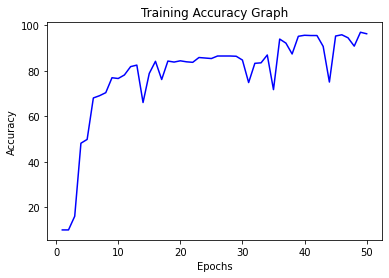

In [27]:
plt.figure()
lenn=range(1,len(train_accuracy)+1)
plt.plot(lenn,train_accuracy,'b')
plt.title('Training Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

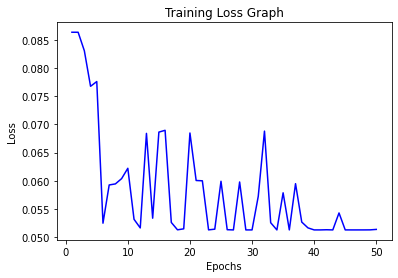

In [28]:
plt.figure()
lenn=range(1,len(train_loss)+1)
plt.plot(lenn,train_loss,'b')
plt.title('Training Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
# Here Train Accuracy : 96%
# Here Test Accuracy : 90%
# I didn't use Validation Set. Just Train Set and Test Set